# Fit BAO peak from input correlation function

In [1]:
import numpy as np
import time

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.bao_model import *
from densitysplit.split_fit import *
from densitysplit.utils import *
from densitysplit.corr_func_utils import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

### Real or redshift space

In [5]:
rsd = True

if rsd:
    ells = [0, 2]
    f = bg.Omega_m(z)**0.55
    sigma_s = 4.
else:
    ells = [0]
    f = 0.
    sigma_s = 0.

### Density split

In [6]:
nells = len(ells)
nsplits = 3
nmocks = 1000

if rsd:
    abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_rh_CCFs_cellsize10_randomsize4_RSD.npy', allow_pickle=True)
    mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_rh_CCF_cellsize10_randomsize4_RSD_all.npy', allow_pickle=True)
else:
    abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_rh_CCFs_cellsize10_randomsize4.npy', allow_pickle=True)
    mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_rh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)    

In [7]:
_, cov = get_split_poles(mocks_split_results, ells, nsplits)
xiell = [abacus_split_results[split].get_corr(ells=ells, return_sep=False) for split in range(nsplits)]

In [8]:
s, _ = abacus_split_results[0].get_corr(ells=ells, return_sep=True)

In [9]:
cov /= 8.

In [10]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

ns = len(s[s > s_lower_limit])
# Hartlap correction
hartlap = (nmocks-1)/(nmocks-ns*nsplits*nells-2)
cov *= hartlap

## Set power spectrum model

In [11]:
bao_model = BAOModel(sep=s, k=np.logspace(-3,2,1000), ells=ells, redshift=z, cosmology=cosmo_abacus, iso=(not rsd), nsplits=nsplits, signature=[True, False, False])

bao_model.set_params(sigma_s=sigma_s)

In [12]:
bao_model.model_params

{'sigma_s': 4.0,
 'alpha_par': 1.0,
 'alpha_perp': 1.0,
 'sigma_par': 8.0,
 'sigma_perp': 3.0,
 'f_DS1': 0.0,
 'b_DS1': 2.0,
 'f_DS2': 0.0,
 'b_DS2': 2.0,
 'f_DS3': 0.0,
 'b_DS3': 2.0,
 'bb0_0_DS1': 0,
 'bb1_0_DS1': 0,
 'bb2_0_DS1': 0,
 'bb0_1_DS1': 0,
 'bb1_1_DS1': 0,
 'bb2_1_DS1': 0,
 'bb0_0_DS2': 0,
 'bb1_0_DS2': 0,
 'bb2_0_DS2': 0,
 'bb0_1_DS2': 0,
 'bb1_1_DS2': 0,
 'bb2_1_DS2': 0,
 'bb0_0_DS3': 0,
 'bb1_0_DS3': 0,
 'bb2_0_DS3': 0,
 'bb0_1_DS3': 0,
 'bb1_1_DS3': 0,
 'bb2_1_DS3': 0}

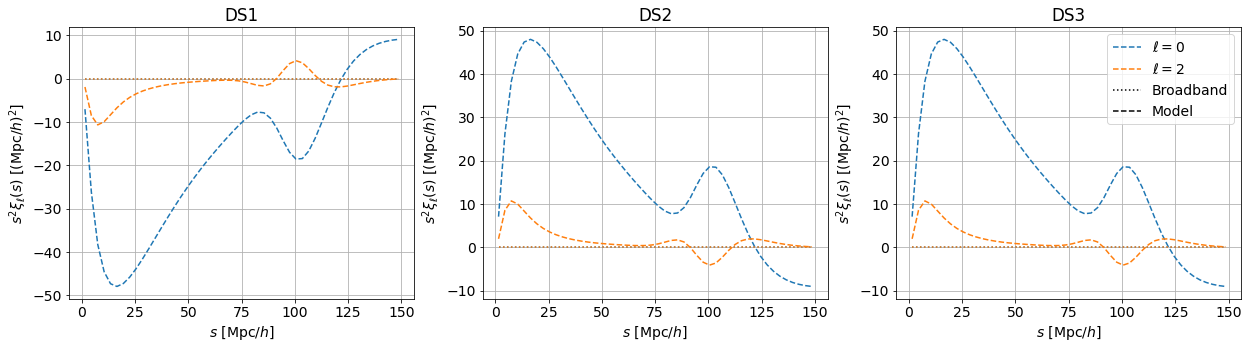

In [13]:
fig, axes = plt.subplots(1, nsplits, figsize=(21, 5), sharey = False)

bao_model.plot_split_model(fig=fig, axes=axes, show_broadband=True)

In [14]:
ds_fit = DensitySplitFit(sep=s, k=np.logspace(-3,2,1000), ells=ells, xiell=xiell, cov=cov, 
                         xi_model=bao_model, model_params=bao_model.model_params, model_params_labels=bao_model.model_params_labels, 
                         nsplits=nsplits)

In [15]:
broadband_coeffs = np.tile([0., 0., 0.], nells)

if rsd:
    params_init = {'f_DS1': f, 'f_DS2': f, 'f_DS3': f, 'b_DS1': 2., 'b_DS2': 2., 'b_DS3': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 8., 'sigma_perp': 3.}
else:
    params_init = {'b_DS1': 2., 'b_DS2': 2., 'b_DS3': 2., 'alpha_iso': 1., 'sigma_iso': 5.}
    
#for split in range(bao_model.nsplits):
#    for ill in range(bao_model.nells):
#        for k in range(3):
#            params_init.update({'bb{}_{}_DS{}'.format(k, ill, split+1): 0.})

t1 = time.time()
ds_fit.fit(fit_params_init=params_init, s_lower_limit=50, fit_method='scipy')
t2 = time.time()
print('Execution time: ', t2-t1)

Optimal parameters:
{'f_DS1': 0.8053691296428954, 'f_DS2': 1.0939025736227537, 'f_DS3': 1.6299318533953702, 'b_DS1': 1.7289573298898537, 'b_DS2': 2.371469506155301, 'b_DS3': 3.466374152822923, 'alpha_par': 0.9775424477661976, 'alpha_perp': 1.020037464264589, 'sigma_par': 8.624992181052091, 'sigma_perp': 10.585631258704042}

Covariance matrix:
[[ 5.94391428e-04  7.52871260e-04  1.13407133e-03 -2.77248877e-04
  -3.56639986e-04 -4.88790791e-04 -1.30462308e-04  9.90962654e-05
  -1.88992954e-03  8.73556693e-04]
 [ 7.52871260e-04  1.04170163e-03  1.32586021e-03 -3.59436779e-04
  -5.23465301e-04 -5.60214183e-04 -1.79218240e-04  1.31978142e-04
  -2.71657409e-03  1.36478462e-03]
 [ 1.13407133e-03  1.32586021e-03  2.38952815e-03 -4.69594830e-04
  -5.31364890e-04 -9.68622319e-04 -2.46118369e-04  2.02374279e-04
  -3.73882554e-03  1.92831131e-03]
 [-2.77248877e-04 -3.59436779e-04 -4.69594830e-04  6.92508745e-04
   8.94982798e-04  1.29438625e-03  1.03008154e-04  3.19343260e-05
   2.33748969e-03  3.8

[000012.81]  06-08 16:27  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000012.81]  06-08 16:27  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000012.82]  06-08 16:27  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000012.82]  06-08 16:27  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000013.08]  06-08 16:27  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000013.08]  06-08 16:27  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000013.09]  06-08 16:27  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000013.09]  06-08 16:27  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


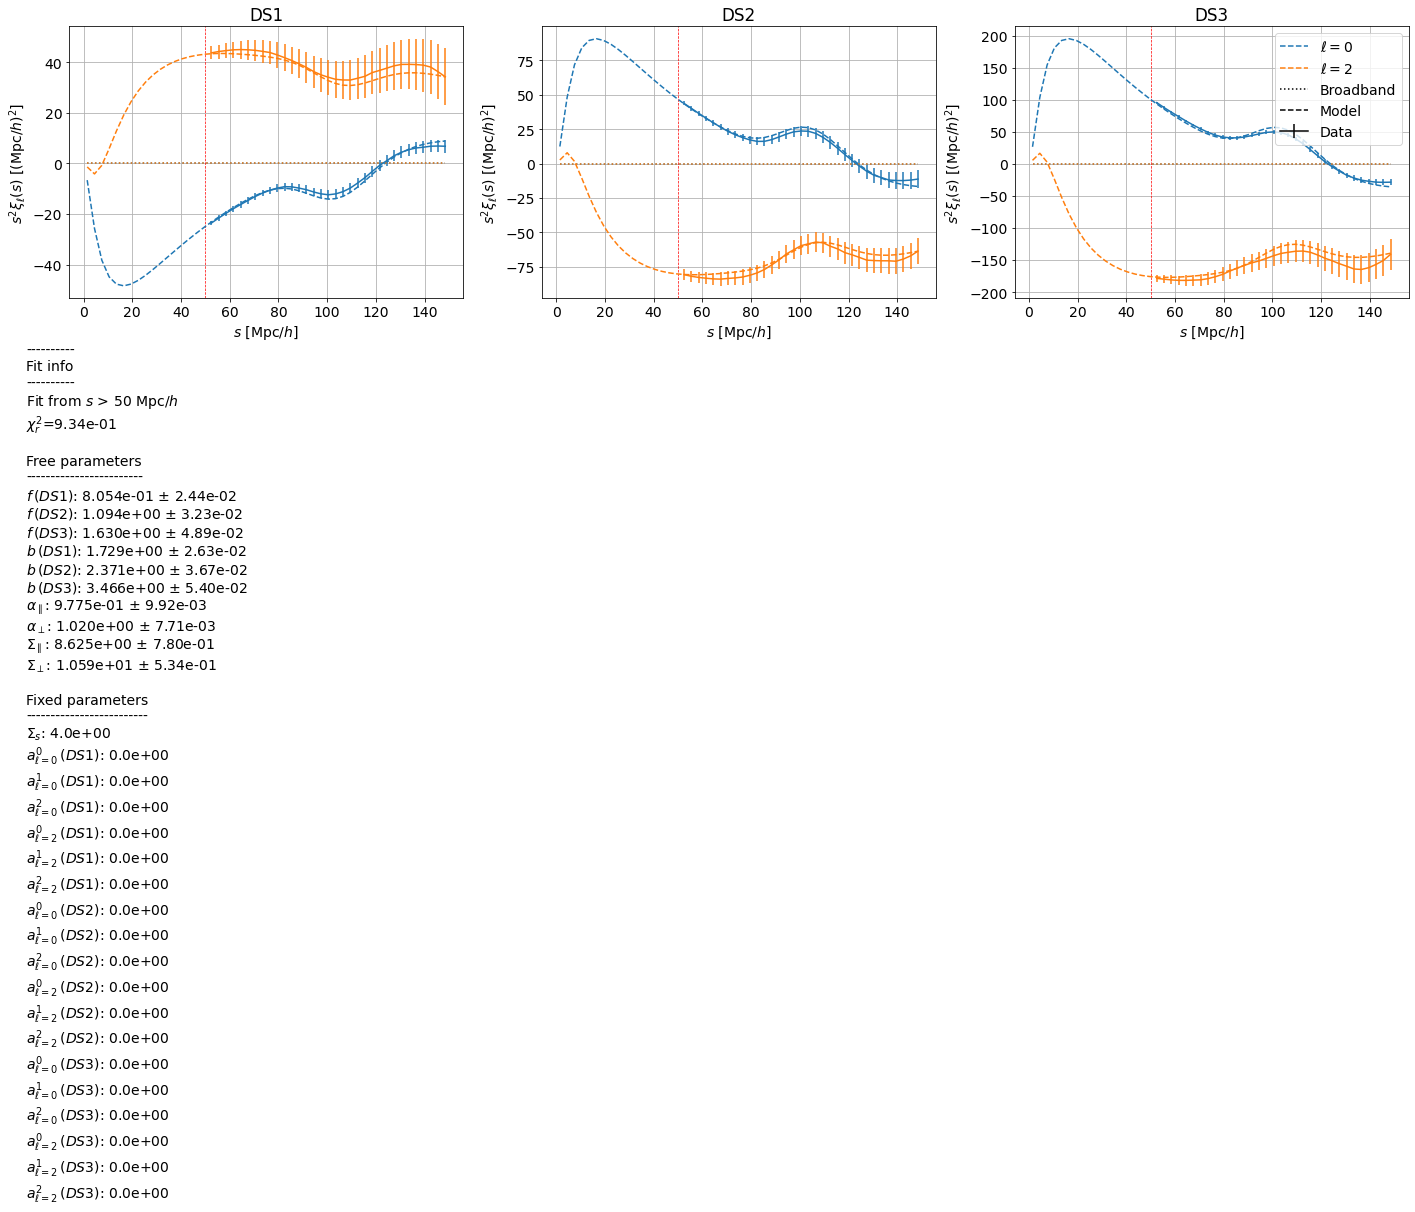

In [16]:
fig, axes = plt.subplots(1, nsplits, figsize=(24, 5), sharey = False)

ds_fit.plot_split_model(fig=fig, axes=axes, show_broadband=True, show_info=True)

/feynman/home/dphp/mp270220/densitysplit/densitysplit/split_fit.py:87: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()


[001790.06]  06-08 16:57  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[001790.06]  06-08 16:57  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[001790.12]  06-08 16:57  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[001790.12]  06-08 16:57  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


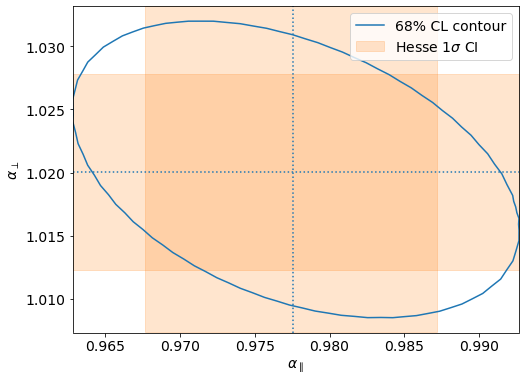

In [17]:
if rsd:
    ds_fit.draw_contour(params=['alpha_par', 'alpha_perp'], free_params_init=params_init)
    
else:
    ds_fit.draw_profile(param='alpha_iso', free_params_init=params_init)
    plt.show()
    ds_fit.draw_profile(param='sigma_iso', free_params_init=params_init)
    plt.show()